# Freely Walking Kinematic Analysis  
#### Code for analyzing fly bowl data to compare walking in different set-ups (linear treadmill, spherical treadmill, fly bowl).
#### Based off of sleap tracking data.
#### Brandon Pratt, 12/20/2023. Code adapted from Su-Yee J. Lee, Tuthill lab 

### Note see corresponding supplementary firectory for files that support this analysis pipeline

In [1]:
# import python libraries
import h5py
import glob
import os
import math
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal
import fnmatch as fn 
import read_data as rd
import organize_data as od
import filled as fl 
import align as al 
import velocity as vel 
import time_align as ta 
from scipy import signal
import compute_tcs as comp_tcs 
import swing_stance_classification as ssc
import estimate_BL as BL 
import compute_swing_distance as swing_dist
import compute_step_distance as step_dist
import swing_stance_duration_vel_based as swing_stance_v
import compute_step_freq_vel as comp_sf_v
import compute_AEP_PEP as comp_AP
import relative_phase_distance as rpd
import align_allocentric as al_a
import os
import os.path
from os import listdir
from os.path import isfile, join
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy.stats import iqr

In [2]:
# use this code to upsample the position data 
# repeat for all legs and x and y 
# def upsample_position(tim)
def upsample_pos(time_align_x_pos, time_align_y_pos): 

    for leg in range(nlegs): 
        input_signal = time_align_x_pos[leg][0]
        trial_duration = 10
        dt = 1/150
        t = np.arange(0, trial_duration, dt) # seconds
        t_upsample = np.arange(0, trial_duration, (1/300)) # seconds
        #extrapolate
        f_upsample = interpolate.interp1d(t, input_signal, fill_value = 'extrapolate')
        pos_upsampled = f_upsample(t_upsample)
        us_x_pos.append(pos_upsampled)

        input_signal = time_align_y_pos[leg][0]
        trial_duration = 10
        dt = 1/150
        t = np.arange(0, trial_duration, dt) # seconds
        t_upsample = np.arange(0, trial_duration, (1/300)) # seconds
        #extrapolate
        f_upsample = interpolate.interp1d(t, input_signal, fill_value = 'extrapolate')
        pos_upsampled = f_upsample(t_upsample)
        us_y_pos.append(pos_upsampled)
    
    return us_x_pos, us_y_pos 
    

In [3]:
# velocity parameters
def test_velocity(hx, hy, FPS):
    dt = 1/FPS

    dx=np.diff(hx)
    dy=np.diff(hy)
    
    # calculate total velocity
    M = np.sqrt(dx**2 + dy**2)
    vel = M/dt 
    # filter the velocity with a 1D Gaussian filter with sigma of 2
    sigma = 2
    filt_vel = gaussian_filter1d(vel, sigma)
    lin_vel = filt_vel
    # calculate the fly's walking speed parallel to the driving speed axis
    vel_parallel = vel = dx/dt
    filt_vel_parallel = gaussian_filter1d(vel_parallel, sigma)
    # calculate the fly's walking speed perpendicular to the driving speed axis
    vel_perpendicular = abs(dy)/dt
    filt_vel_perpendicular = gaussian_filter1d(vel_perpendicular, sigma)
    
    return filt_vel, filt_vel_parallel, filt_vel_perpendicular

In [4]:
# function to upsample data
def upsample_data(input_signal, org_fps, new_fps):
    dt = 1/org_fps
    t = np.arange(0, len(input_signal)*dt, dt) # seconds
    if len(t) > len(input_signal):
        t = t[0:len(input_signal)]
    t_upsample = np.arange(0, len(input_signal)*dt, (1/new_fps)) # seconds
    #extrapolate
    f_upsample = interpolate.interp1d(t, input_signal, fill_value = 'extrapolate')
    vel_upsampled = f_upsample(t_upsample)

    return vel_upsampled

In [99]:
def upsample_kinematics(x_pos, y_pos, new_x_pos, frame_idx):
    # upsample step velocity signal to match the temporal sampling of the spherical treadmill
    nlegs = 6     
    up_fps = 300
    org_fps = 150
    dt = 1/org_fps
    
    # unsigned speed - can't be signed in this case
    r1_vel = np.sqrt(np.diff(x_pos[0])**2 + np.diff(y_pos[0])**2)/dt
    r2_vel = np.sqrt(np.diff(x_pos[1])**2 + np.diff(y_pos[1])**2)/dt
    r3_vel = np.sqrt(np.diff(x_pos[2])**2 + np.diff(y_pos[2])**2)/dt
    l1_vel = np.sqrt(np.diff(x_pos[3])**2 + np.diff(y_pos[3])**2)/dt
    l2_vel = np.sqrt(np.diff(x_pos[4])**2 + np.diff(y_pos[4])**2)/dt
    l3_vel = np.sqrt(np.diff(x_pos[5])**2 + np.diff(y_pos[5])**2)/dt
    
    # add sign based on ego-centric x positions
    r1_vel[np.diff(new_x_pos[0])<0] = -r1_vel[np.diff(new_x_pos[0])<0]
    r2_vel[np.diff(new_x_pos[1])<0] = -r2_vel[np.diff(new_x_pos[1])<0]
    r3_vel[np.diff(new_x_pos[2])<0] = -r3_vel[np.diff(new_x_pos[2])<0]
    l1_vel[np.diff(new_x_pos[3])<0] = -l1_vel[np.diff(new_x_pos[3])<0]
    l2_vel[np.diff(new_x_pos[4])<0] = -l2_vel[np.diff(new_x_pos[4])<0]
    l3_vel[np.diff(new_x_pos[5])<0] = -l3_vel[np.diff(new_x_pos[5])<0]

    # smooth velocities using a gaussian filter
    s = 1.5 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)
    
    # upsample velocities
    r1_upsampled_vel = upsample_data(r1_smoothed_vel, org_fps, up_fps)
    r2_upsampled_vel = upsample_data(r2_smoothed_vel, org_fps, up_fps)
    r3_upsampled_vel = upsample_data(r3_smoothed_vel, org_fps, up_fps)
    l1_upsampled_vel = upsample_data(l1_smoothed_vel, org_fps, up_fps)
    l2_upsampled_vel = upsample_data(l2_smoothed_vel, org_fps, up_fps)
    l3_upsampled_vel = upsample_data(l3_smoothed_vel, org_fps, up_fps)
    
    # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, len(r1_upsampled_vel)+1])
    velocity_threshold = 15 # velocities above 15 mm/s are classified as swing - same as treadmill classification code
    swing_stance_mat[0, np.concatenate((np.array([[r1_upsampled_vel < velocity_threshold][0][0]]), r1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_upsampled_vel < velocity_threshold][0][0]]), r2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_upsampled_vel < velocity_threshold][0][0]]), r3_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_upsampled_vel < velocity_threshold][0][0]]), l1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_upsampled_vel < velocity_threshold][0][0]]), l2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_upsampled_vel < velocity_threshold][0][0]]), l3_upsampled_vel < velocity_threshold))] = 1
    
#     # remove discontinuities
#     for leg in range(6):
#         for i in [3,4,3]:
#             for j in range(swing_stance_mat.shape[1]-(i-1)):
#                 if swing_stance_mat[leg,j] == swing_stance_mat[leg,j+(i-1)] and swing_stance_mat[leg,j+1] != swing_stance_mat[leg,j] and np.all(swing_stance_mat[leg,j+1:j+(i-1)]== swing_stance_mat[leg,j+1]):
#                     swing_stance_mat[leg,j+1:j+(i-1)] = swing_stance_mat[leg,j]
    
    
    # swing and stance transitions
    upsampled_stance_start = []
    upsampled_stance_end = []
    upsampled_all_frames = np.arange(0, len(r1_upsampled_vel)+1)
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]
        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx]
        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)
        # append stance start and end data across legs
        upsampled_stance_start.append(leg_stance_starts)
        upsampled_stance_end.append(leg_stance_end)
    
    # Compute temporal kinematics with the upsampled signal
    # initialize timing parameters
    trial_samples = 1500
    
    '''Step Frequency'''
    upsampled_step_frequency =  np.empty((nlegs, trial_samples))
    upsampled_step_frequency[:] = np.nan
    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            step_duration=(upsampled_stance_start[leg][j+1] - upsampled_stance_start[leg][j])/up_fps
            if step_duration>0:
                org_idx = int(frame_idx[int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))])
                upsampled_step_frequency[leg, org_idx] = 1/step_duration
    
    '''Stance and Swing Duration'''
    upsampled_stance_duration =  np.empty((nlegs, trial_samples))
    upsampled_stance_duration[:] = np.nan
    upsampled_swing_duration =  np.empty((nlegs, trial_samples))
    upsampled_swing_duration[:] = np.nan
    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            stance_delt=(upsampled_stance_end[leg][j]-upsampled_stance_start[leg][j])/up_fps
            if stance_delt > 0:
                org_idx = int(frame_idx[int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))])
                upsampled_stance_duration[leg, org_idx] = stance_delt
            swing_delt=(upsampled_stance_start[leg][j+1] - upsampled_stance_end[leg][j])/up_fps
            if swing_delt > 0:
                org_idx = int(frame_idx[int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))])
                upsampled_swing_duration[leg, org_idx] = swing_delt

    return upsampled_step_frequency, upsampled_stance_duration, upsampled_swing_duration


In [111]:
'''Original Sampling Rate'''
def step_kinematics_coordination(x_pos, y_pos, new_x_pos, frame_idx):
    # upsample step velocity signal to match the temporal sampling of the spherical treadmill
    nlegs = 6     
    org_fps = 150
    dt = 1/org_fps
    
    # unsigned speed - can't be signed in this case
    r1_vel = np.sqrt(np.diff(x_pos[0])**2 + np.diff(y_pos[0])**2)/dt
    r2_vel = np.sqrt(np.diff(x_pos[1])**2 + np.diff(y_pos[1])**2)/dt
    r3_vel = np.sqrt(np.diff(x_pos[2])**2 + np.diff(y_pos[2])**2)/dt
    l1_vel = np.sqrt(np.diff(x_pos[3])**2 + np.diff(y_pos[3])**2)/dt
    l2_vel = np.sqrt(np.diff(x_pos[4])**2 + np.diff(y_pos[4])**2)/dt
    l3_vel = np.sqrt(np.diff(x_pos[5])**2 + np.diff(y_pos[5])**2)/dt
    
    # add sign based on ego-centric x positions
    r1_vel[np.diff(new_x_pos[0])<0] = -r1_vel[np.diff(new_x_pos[0])<0]
    r2_vel[np.diff(new_x_pos[1])<0] = -r2_vel[np.diff(new_x_pos[1])<0]
    r3_vel[np.diff(new_x_pos[2])<0] = -r3_vel[np.diff(new_x_pos[2])<0]
    l1_vel[np.diff(new_x_pos[3])<0] = -l1_vel[np.diff(new_x_pos[3])<0]
    l2_vel[np.diff(new_x_pos[4])<0] = -l2_vel[np.diff(new_x_pos[4])<0]
    l3_vel[np.diff(new_x_pos[5])<0] = -l3_vel[np.diff(new_x_pos[5])<0]

    # smooth velocities using a gaussian filter
    s = 1.5 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)
        
    # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, len(r1_smoothed_vel)+1])
    velocity_threshold = 15# velocities above 15 mm/s are classified as swing - same as treadmill classification code
    swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel < velocity_threshold][0][0]]), r1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel < velocity_threshold][0][0]]), r2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel < velocity_threshold][0][0]]), r3_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel < velocity_threshold][0][0]]), l1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel < velocity_threshold][0][0]]), l2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel < velocity_threshold][0][0]]), l3_smoothed_vel < velocity_threshold))] = 1
    
#     # remove discontinuities
#     for leg in range(6):
#         for i in [3,4,3]:
#             for j in range(swing_stance_mat.shape[1]-(i-1)):
#                 if swing_stance_mat[leg,j] == swing_stance_mat[leg,j+(i-1)] and swing_stance_mat[leg,j+1] != swing_stance_mat[leg,j] and np.all(swing_stance_mat[leg,j+1:j+(i-1)]== swing_stance_mat[leg,j+1]):
#                     swing_stance_mat[leg,j+1:j+(i-1)] = swing_stance_mat[leg,j]
    
    # swing and stance transitions
    stance_start = []
    stance_end = []
    all_frames = np.arange(0, len(r1_smoothed_vel)+1)
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]
        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx]
        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)
        # append stance start and end data across legs
        stance_start.append(leg_stance_starts)
        stance_end.append(leg_stance_end)
    
    # Compute temporal kinematics with the upsampled signal
    # initialize timing parameters
    trial_samples = 1500
    
    '''Step Frequency'''
    step_frequency =  np.empty((nlegs, trial_samples))
    step_frequency[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            step_duration=(stance_start[leg][j+1] - stance_start[leg][j])/org_fps
            if step_duration>0:
                step_frequency[leg, int(frame_idx[stance_start[leg][j]])] = 1/step_duration
    
    '''Stance and Swing Duration'''
    stance_duration =  np.empty((nlegs, trial_samples))
    stance_duration[:] = np.nan
    swing_duration =  np.empty((nlegs, trial_samples))
    swing_duration[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            stance_delt=(stance_end[leg][j]-stance_start[leg][j])/org_fps
            if stance_delt > 0:
                stance_duration[leg, int(frame_idx[stance_start[leg][j]])] = stance_delt
            swing_delt=(stance_start[leg][j+1] - stance_end[leg][j])/org_fps
            if swing_delt > 0:
                swing_duration[leg, int(frame_idx[stance_start[leg][j]])] = swing_delt
                
    '''Step Length'''
    # allocentric distance between stance onset to the subsequent stance onset
    step_length =  np.empty((nlegs, trial_samples))
    step_length[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            x_dist = x_pos[leg][stance_start[leg][j]:stance_start[leg][j+1]]
            y_dist = y_pos[leg][stance_start[leg][j]:stance_start[leg][j+1]]
            tot_dist = np.nansum(np.sqrt(np.diff(x_dist)**2 + np.diff(y_dist)**2))
            
            if tot_dist > 0:
                step_length[leg, int(frame_idx[stance_start[leg][j]])] = tot_dist
                
    '''Relative Phase'''
    # relative phase between L1 and other legs
    leg_comparasions = [[3,0], [3,1], [3,2], [3,4], [3,5]]
    step_phase = -np.ones((len(leg_comparasions), trial_samples))

    for j in range(len(leg_comparasions)):
        leg1 = leg_comparasions[j][0]
        leg2 = leg_comparasions[j][1]

        for i in range(len(stance_start[leg1])-1):
            stance_index = stance_start[leg2][np.logical_and(stance_start[leg2] >= stance_start[leg1][i], stance_start[leg2] < stance_start[leg1][i+1])]

            if len(stance_index) > 0: # make sure there is a match - only consider the first index
                step_phase[j, int(frame_idx[stance_start[leg1][i]])] = (stance_index[0]-stance_start[leg1][i])/(stance_start[leg1][i+1]-stance_start[leg1][i])
    
    '''Number of Leg in Stance'''
    nlegs_stance =  np.empty(trial_samples)
    nlegs_stance[:] = np.nan
    nlegs_stance[frame_idx.astype(int)] = np.sum(swing_stance_mat, axis = 0)
    

    return step_frequency, stance_duration, swing_duration, step_length, step_phase, nlegs_stance, swing_stance_mat


### Behavior classifier

Use a heading horizon and isolate forward walking bouts

In [7]:
def fw_classifier(body_pos, filt_vel, frame_idx, bout_counter, heading_tol, angle_threshold):

    '''STEP 1: Segment the trajectory into linear portions'''
    # smooth thorax trajectory to remove jitteriness
    tx_s = gaussian_filter1d(body_pos[2], 2)
    ty_s = gaussian_filter1d(body_pos[3], 2)

    # compute the angle between line segments using the law of cosines

    # 3 sample points
    angle_seg = np.zeros(len(tx_s)-2)
    for j in range(len(tx_s)-2):
        # law of cosine sides
        a = np.sqrt((tx_s[j] - tx_s[j+2])**2 + (ty_s[j] - ty_s[j+2])**2)
        b = np.sqrt((tx_s[j+1] - tx_s[j+2])**2 + (ty_s[j+1] - ty_s[j+2])**2)
        c = np.sqrt((tx_s[j] - tx_s[j+1])**2 + (ty_s[j] - ty_s[j+1])**2)

        angle_seg[j] = 180 - math.degrees(math.acos((b**2 + c**2 - a**2)/(2*b*c)))

    # glob segments together
#     angle_threshold = 3 # empirically determined (Tunable Parameter)
    seg_id = np.zeros(len(angle_seg)) # assign a unique segment id to each classified sement
    seg_cnt = 0
    for j in range(len(angle_seg)-1):
        if angle_seg[j+1] >= angle_threshold:
            seg_cnt += 1
            seg_id[j+1] = seg_cnt
        else:
            seg_id[j+1] = seg_cnt

    # Assign frame numbers to each unique segment
    seg_frames = np.zeros((len(np.unique(seg_id)), 2))
    start_idx = 0
    for j in range(seg_frames.shape[0]):
        n_segments = len(np.where(seg_id == j)[0]) -1
        if j == 0 or j == seg_frames.shape[0]-1: # fix edges
            n_segments = n_segments + 1
        if n_segments == 1:
            end_idx = start_idx
        else:
            end_idx = n_segments + start_idx
        seg_frames[j,0] = start_idx
        seg_frames[j,1] = end_idx
        start_idx = end_idx + 1
    seg_frames = seg_frames.astype(int)    

    '''STEP 2: iterate through segments and classify trajectory as forward based on average speed and heading'''   
    # heading angle
    norm_hx = gaussian_filter1d(body_pos[0] - body_pos[2], 2)
    norm_hy = gaussian_filter1d(body_pos[1] - body_pos[3], 2)

    heading_angle = np.zeros(len(norm_hx))
    for j in range(len(norm_hx)):
        heading_angle[j] = math.degrees(math.atan2(norm_hy[j], norm_hx[j])) 

    # append to vel to make it the proper length
    walking_speed = np.concatenate((np.array([filt_vel[0]]), filt_vel))

    # classification parameters
    vel_threshold = 5 # mm/s
#     heading_tol = 10 # iqr - empirically determined (Tunable Parameter)
    walking_bout_threshold = 30 # equates to 200 ms

    fw_classification = np.zeros(len(frame_idx))
    walking_bout_id = np.zeros(len(frame_idx))

    # iterate through straight trajectories
    for j in range(seg_frames.shape[0]):
        num_frames = seg_frames[j,1] - seg_frames[j,0]
        if num_frames >= walking_bout_threshold:
            vel_bout = np.mean(walking_speed[seg_frames[j,0]:seg_frames[j,1]+1])
            heading_bout = iqr(heading_angle[seg_frames[j,0]:seg_frames[j,1]+1])

            # filter based on the velocity and heading
            if (vel_bout >= vel_threshold) and (heading_bout <= heading_tol):
                bout_counter += 1
                fw_classification[seg_frames[j,0]:seg_frames[j,1]+1] = 1 # 1 indicates walking
                walking_bout_id[seg_frames[j,0]:seg_frames[j,1]+1] = bout_counter
                
    return fw_classification, walking_bout_id, bout_counter, heading_angle

In [8]:
def filter_kinematics(upsampled_step_frequency, upsampled_stance_duration, upsampled_swing_duration, step_frequency, stance_duration, swing_duration, step_length, step_phase):

    # filtering mask
    stance_upper_lim = 0.2 # s
    swing_upper_lim = 0.075 # s
    swing_lower_lim = 0.02 # s
    step_freq_upper_lim = 20
    step_freq_lower_lim = 5

    # filtered versions of each kinematic parameter
    filt_step_freq_upsampled = np.copy(upsampled_step_frequency) 
    filt_stance_duration_upsampled = np.copy(upsampled_stance_duration) 
    filt_swing_duration_upsampled = np.copy(upsampled_swing_duration) 

    # iterate through legs
    for j in range(filt_step_freq_upsampled.shape[0]):
        step_freq_filter_idxs = np.logical_or(upsampled_step_frequency[j] < step_freq_lower_lim, upsampled_step_frequency[j] > step_freq_upper_lim)
        swing_duration_filter_idxs = np.logical_or(upsampled_swing_duration[j] < swing_lower_lim, upsampled_swing_duration[j] > swing_upper_lim)
        stance_duration_filter_idxs = upsampled_stance_duration[j] > stance_upper_lim

        # reduce indices
        filter_idxs = np.logical_or.reduce((step_freq_filter_idxs, swing_duration_filter_idxs, stance_duration_filter_idxs))

        # filter upsampled kinematics
        filt_step_freq_upsampled[j][filter_idxs] = np.nan
        filt_stance_duration_upsampled[j][filter_idxs] = np.nan
        filt_swing_duration_upsampled[j][filter_idxs] = np.nan


    # repeat above but for orignally sampled kinematics
    # filtered versions of each kinematic parameter
    filt_step_freq = np.copy(step_frequency) 
    filt_stance_duration = np.copy(stance_duration) 
    filt_swing_duration = np.copy(swing_duration)  
    filt_step_length = np.copy(step_length)
    filt_phase = np.copy(step_phase)

    # intraleg kinematics
    for j in range(filt_step_freq.shape[0]):
        step_freq_filter_idxs = np.logical_or(step_frequency[j] < step_freq_lower_lim, step_frequency[j] > step_freq_upper_lim)
        swing_duration_filter_idxs = np.logical_or(swing_duration[j] < swing_lower_lim, swing_duration[j] > swing_upper_lim)
        stance_duration_filter_idxs = stance_duration[j] > stance_upper_lim

        # reduce indices
        filter_idxs = np.logical_or.reduce((step_freq_filter_idxs, swing_duration_filter_idxs, stance_duration_filter_idxs))

        # filter upsampled kinematics
        filt_step_freq[j][filter_idxs] = np.nan
        filt_stance_duration[j][filter_idxs] = np.nan
        filt_swing_duration[j][filter_idxs] = np.nan
        filt_step_length[j][filter_idxs] = np.nan

    #interleg coordination
    step_freq_filter_idxs = np.logical_or(step_frequency[3] < step_freq_lower_lim, step_frequency[3] > step_freq_upper_lim)
    swing_duration_filter_idxs = np.logical_or(swing_duration[3] < swing_lower_lim, swing_duration[3] > swing_upper_lim)
    stance_duration_filter_idxs = stance_duration[3] > stance_upper_lim
    for j in range(filt_phase.shape[0]):
        # reduce indices
        filter_idxs = np.logical_or.reduce((step_freq_filter_idxs, swing_duration_filter_idxs, stance_duration_filter_idxs))
        filt_phase[j][filter_idxs] = -1
        
    return filt_step_freq_upsampled, filt_stance_duration_upsampled, filt_swing_duration_upsampled, filt_step_freq, filt_stance_duration, filt_swing_duration, filt_step_length, filt_phase
    

In [9]:
# body length
def estimate_BL(body_pos, fw_classification):
    
    if np.any(fw_classification==1):
        idxs = np.where(fw_classification==1)[0]
        
        # head coordinates
        hx = body_pos[0][idxs]
        hy = body_pos[1][idxs]

        # abdomen coordinates
        ax = body_pos[4][idxs]
        ay = body_pos[5][idxs]
        
    else:
        # head coordinates
        hx = body_pos[0]
        hy = body_pos[1]

        # abdomen coordinates
        ax = body_pos[4]
        ay = body_pos[5]

    # compute the difference
    dx = hx - ax
    dy = hy - ay

    # Calculate the body lengths for the trial
    BL = np.sqrt(dx**2 + dy**2)

    # calculate the median BL
    return np.median(BL)

In [112]:
# Iterate through videos, group data together, calculate velocity, step metrics, 

# access folder with data files (.h5 files of sleap tracked videos) 
data_dir = "C:/Users/pratt/Desktop/Analysis/Free_Walking/wtberlin_multi/"
filenames = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]

# initialize some variables
h5_filename = [] 
filtered_filename = []
global_variables = []


# define some variables 
genotype = '*wtberlin*'#'*Ms*' # genotype / cohort name to query directory for 
genotype_name = 'wtberlin_v14_us'#'Ms'# save name "genotype_name.npy"
FPS = 150 
trial_samples = 1500 # 10 seconds
nlegs = 6 

# find all .h5 files with tracked SLEAP data 
for file in range(len(filenames)):
    if filenames[file][-3::] =='.h5':
        h5_filename.append(filenames[file])  
        
# search files for genotype / cohort of interest         
for aa in range(0, len(h5_filename)): #[0]:   
    if fn.fnmatch(h5_filename[aa], genotype):
        filtered_filename.append(h5_filename[aa])

'''Initialize Parameters'''
median_BL_store = []
track_analyzed = []
vid_analyzed = []
frames_analyzed = []
bout_counter = 0 # walking bout counter - unique identifier for each bout
track_counter = -1

    
# iterate through each tracked video file 
for j in range(len(filtered_filename)): #[0]:   
    curr_file = filtered_filename[j]
    print(curr_file)
    [data, valid_frame_idxs, tracks, numflies] = rd.read_data(data_dir+curr_file)
    headers = tracks.columns.tolist() #list headers 

    # reorganize data for each instance/ track 
    for fly in range(0, len(numflies)): 
        
        curfly = numflies[fly]
        print(curfly)
        fly_df = tracks[tracks[headers[0]] == curfly] # dataframe associated with a track
  
        # get trajectory
        frame_idx, raw_positions = od.organize_data(fly_df)
        x_pos, y_pos, body_pos, x_pos_ego, y_pos_ego, body_pos_ego = fl.filled(raw_positions) # separate leg positions from body positions (head, abdomen, thorax)
        _, rot_vel,new_x_pos, new_y_pos, _, _ =al_a.align_allocentric(x_pos_ego, y_pos_ego, body_pos_ego) # reorient positions to common heading angle, normalized to thorax (egocentric)
        filt_vel, _, _ = test_velocity(body_pos[2], body_pos[3], FPS) # velocity
                
        ''' Compute leg kinematics if trajectories are long enough'''
        if len(frame_idx) >= 30: # trajectories of at least 200 ms
            track_counter += 1
            
            # upsampled step parameters
            upsampled_step_frequency, upsampled_stance_duration, upsampled_swing_duration = upsample_kinematics(x_pos, y_pos, new_x_pos, frame_idx)
            
            # original step parameters
            step_frequency, stance_duration, swing_duration, step_length, step_phase, nlegs_stance, swing_stance_mat = step_kinematics_coordination(x_pos, y_pos, new_x_pos, frame_idx)
            
            # filter data based on forward walking filter
            angle_threshold = 4.5 # empirically determined (Tunable Parameter) - 4.5
            heading_tol = 20 #17.5 # iqr - empirically determined (Tunable Parameter) - 20
            fw_classification, walking_bout_id, bout_counter, heading_angle = fw_classifier(body_pos, filt_vel, frame_idx, bout_counter, heading_tol, angle_threshold)
            
            # filter data based on unrealistic kinematics
            filt_step_freq_upsampled, filt_stance_duration_upsampled, filt_swing_duration_upsampled, filt_step_freq, filt_stance_duration, filt_swing_duration, filt_step_length, filt_phase = filter_kinematics(upsampled_step_frequency, upsampled_stance_duration, upsampled_swing_duration, step_frequency, stance_duration, swing_duration, step_length, step_phase)
            track_analyzed.append(1)
            
            # compute body length - if fw present, provide a more accurate estimate
            med_BL = estimate_BL(body_pos, fw_classification)
            # correct for inaccurate body length estimates - use the median
            if med_BL > 5:
                med_BL = np.median(median_BL_store)
            median_BL_store.append(med_BL)
            vid_analyzed.append(curr_file)
            frames_analyzed.append(frame_idx)

            # concatenate data across tracks
            if track_counter == 0:
                # upsampled
                upsampled_step_freq_store = np.expand_dims(filt_step_freq_upsampled, axis = 2)
                upsampled_stance_duration_store = np.expand_dims(filt_stance_duration_upsampled, axis = 2)
                upsampled_swing_duration_store = np.expand_dims(filt_swing_duration_upsampled, axis = 2)

                # org sampling
                step_freq_store = np.expand_dims(filt_step_freq, axis = 2)
                stance_duration_store = np.expand_dims(filt_stance_duration, axis = 2)
                swing_duration_store = np.expand_dims(filt_swing_duration, axis = 2)
                step_length_store = np.expand_dims(filt_step_length/med_BL, axis = 2)
                step_phase_store = np.expand_dims(filt_phase, axis = 2)

                # global metrics
                vel_temp_store = np.empty(trial_samples)
                vel_temp_store[:] = np.nan
                vel_temp_store[frame_idx.astype(int)] = np.concatenate((np.array([filt_vel[0]]), filt_vel))/med_BL # converted to BL
                vel_store = vel_temp_store

                fw_class_temp_store = np.empty(trial_samples)
                fw_class_temp_store[:] = np.nan
                fw_class_temp_store[frame_idx.astype(int)] = fw_classification
                fw_class_store = fw_class_temp_store

                bout_id_temp_store = np.empty(trial_samples)
                bout_id_temp_store[:] = np.nan
                bout_id_temp_store[frame_idx.astype(int)] = walking_bout_id
                bout_id_store = bout_id_temp_store
    
                nlegs_store = nlegs_stance
        
                # swing stance mat
                temp_swing_stance =  np.empty((nlegs, trial_samples))
                temp_swing_stance[:] = np.nan
                temp_swing_stance[:, frame_idx.astype(int)] = swing_stance_mat
                swing_stance_store = np.expand_dims(temp_swing_stance, axis = 2)
                
            else: # concatenate everything
                # upsampled
                upsampled_step_freq_store = np.concatenate((upsampled_step_freq_store ,np.expand_dims(filt_step_freq_upsampled, axis = 2)), axis = 2)
                upsampled_stance_duration_store = np.concatenate((upsampled_stance_duration_store ,np.expand_dims(filt_stance_duration_upsampled, axis = 2)), axis = 2)
                upsampled_swing_duration_store = np.concatenate((upsampled_swing_duration_store ,np.expand_dims(filt_swing_duration_upsampled, axis = 2)), axis = 2)

                # org sampling
                step_freq_store = np.concatenate((step_freq_store ,np.expand_dims(filt_step_freq, axis = 2)), axis = 2)
                stance_duration_store = np.concatenate((stance_duration_store ,np.expand_dims(filt_stance_duration, axis = 2)), axis = 2)
                swing_duration_store = np.concatenate((swing_duration_store ,np.expand_dims(filt_swing_duration, axis = 2)), axis = 2)
                step_length_store = np.concatenate((step_length_store ,np.expand_dims(filt_step_length/med_BL, axis = 2)), axis = 2)
                step_phase_store = np.concatenate((step_phase_store ,np.expand_dims(filt_phase, axis = 2)), axis = 2)

                # global metrics
                vel_temp_store = np.empty(trial_samples)
                vel_temp_store[:] = np.nan
                vel_temp_store[frame_idx.astype(int)] = np.concatenate((np.array([filt_vel[0]]), filt_vel))/med_BL # converted to BL
                vel_store = np.vstack((vel_store, vel_temp_store))

                fw_class_temp_store = np.empty(trial_samples)
                fw_class_temp_store[:] = np.nan
                fw_class_temp_store[frame_idx.astype(int)] = fw_classification
                fw_class_store = np.vstack((fw_class_store, fw_class_temp_store))

                bout_id_temp_store = np.empty(trial_samples)
                bout_id_temp_store[:] = np.nan
                bout_id_temp_store[frame_idx.astype(int)] = walking_bout_id
                bout_id_store = np.vstack((bout_id_store, bout_id_temp_store))
                
                # number of legs in stance
                nlegs_store = np.vstack((nlegs_store, nlegs_stance))
                
                # swing stance mat
                temp_swing_stance =  np.empty((nlegs, trial_samples))
                temp_swing_stance[:] = np.nan
                temp_swing_stance[:, frame_idx.astype(int)] = swing_stance_mat
                swing_stance_store = np.concatenate((swing_stance_store , np.expand_dims(temp_swing_stance, axis = 2)), axis = 2)
                
        else:
            track_analyzed.append(0)
                
track_analyzed = np.array(track_analyzed)        
median_BL_store = np.array(median_BL_store) # convert list to array           
print('Number of Walking Bouts = ', bout_counter-1)
print('Percent Tracks Analyzed = ', 100*(len(np.where(track_analyzed==1)[0])/len(track_analyzed)))

genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m10_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m10_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m10_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'i

track_2
track_3
genotype_wtberlin_m12_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m12_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (7, 1500)
point_scores: float64 array of shape (7, 11, 1500)
track_occupancy: bool array of shape (1500, 7)
tracking_scores: float64 array of shape (7, 1500)
tracks: float64 array of shape (1500, 11, 2, 7)
video_path: b'genotype_wtberlin_m12_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
track_5
track_6
genotype_wtberlin_m12_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m12_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys 

edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m14_trail_type_walk_session_1_repeat_3Camera1.mp4'
track_0
genotype_wtberlin_m14_trail_type_walk_session_1_repeat_4Camera1.mp4.000_genotype_wtberlin_m14_trail_type_walk_session_1_repeat_4Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape 

track_0
genotype_wtberlin_m19_trail_type_nostim_session_1_repeat_5Camera1.mp4.000_genotype_wtberlin_m19_trail_type_nostim_session_1_repeat_5Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m19_trail_type_nostim_session_1_repeat_5Camera1.mp4'
track_0
track_1
genotype_wtberlin_m1_trail_type_nostim_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m1_trail_type_nostim_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_na

edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m22_trail_type_nostim_session_3_repeat_3Camera1.mp4'
track_0
genotype_wtberlin_m23_trail_type_nostim_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m23_trail_type_nostim_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of 

genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m2_trail_type_nostim_session_1_repeat_1Camera1.mp4'
track_0
track_1
genotype_wtberlin_m2_trail_type_walik_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m2_trail_type_walik_session_1_repeat_1Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instan

edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of shape (1500, 1)
tracking_scores: float64 array of shape (1, 1500)
tracks: float64 array of shape (1500, 11, 2, 1)
video_path: b'genotype_wtberlin_m35_trail_type_nostim_session_1_repeat_4Camera1.mp4'
track_0
genotype_wtberlin_m37_trail_type_nostim_session_1_repeat_4Camera1.mp4.000_genotype_wtberlin_m37_trail_type_nostim_session_1_repeat_4Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (1, 1500)
point_scores: float64 array of shape (1, 11, 1500)
track_occupancy: bool array of 

genotype_wtberlin_m41_trail_type_nostim_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m41_trail_type_nostim_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (2, 1500)
point_scores: float64 array of shape (2, 11, 1500)
track_occupancy: bool array of shape (1500, 2)
tracking_scores: float64 array of shape (2, 1500)
tracks: float64 array of shape (1500, 11, 2, 2)
video_path: b'genotype_wtberlin_m41_trail_type_nostim_session_1_repeat_2Camera1.mp4'
track_0
track_1
genotype_wtberlin_m41_trail_type_nostim_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m41_trail_type_nostim_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 

tracks: float64 array of shape (1500, 11, 2, 5)
video_path: b'genotype_wtberlin_m7_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
track_3
track_4
genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.mp4.000_genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m7_trail_type_walk_session_1_repeat_3Camera1.mp4'
track_0
track_1
track_2
genotype_wtberlin_m7_trail_type_wa

track_2
genotype_wtberlin_m9_trail_type_walk_session_1_repeat_2Camera1.mp4.000_genotype_wtberlin_m9_trail_type_walk_session_1_repeat_2Camera1.analysis.h5
Keys in the HDF5 file: ['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']
edge_inds: int64 array of shape (10, 2)
edge_names: |S7 array of shape (10, 2)
instance_scores: float64 array of shape (3, 1500)
point_scores: float64 array of shape (3, 11, 1500)
track_occupancy: bool array of shape (1500, 3)
tracking_scores: float64 array of shape (3, 1500)
tracks: float64 array of shape (1500, 11, 2, 3)
video_path: b'genotype_wtberlin_m9_trail_type_walk_session_1_repeat_2Camera1.mp4'
track_0
track_1
track_2
Number of Walking Bouts =  232
Percent Tracks Analyzed =  79.9373040752351


### Plot example swing and stance plots

genotype_wtberlin_m8_trail_type_walk_session_1_repeat_1Camera1.mp4.000_genotype_wtberlin_m8_trail_type_walk_session_1_repeat_1Camera1
[393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410
 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428
 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446
 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462]
N Frames =  75
Walking Speed (BL/s) =  10.377059269358671


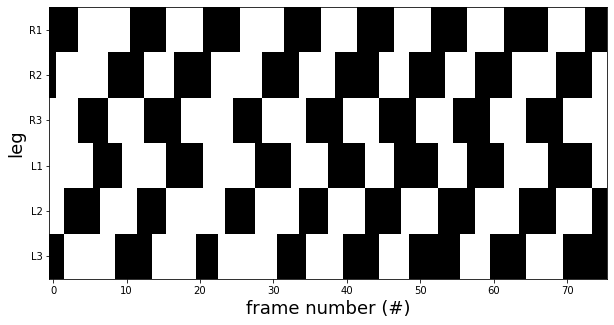

In [124]:
figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/fly_bowl/new_plots/'
example_traj = 227
print(vid_analyzed[example_traj][0:-12])
print(np.where(fw_class_store[example_traj,:]==1)[0])
start_frame = 387
end_frame = 462
walking_frames = np.arange(start_frame, end_frame+1)
print('N Frames = ', end_frame-start_frame)
print('Walking Speed (BL/s) = ', np.mean(vel_store[example_traj,start_frame:end_frame+1]))

# plot swing stance
fig = plt.figure(1, figsize=[10,5])
plt.xlabel('frame number (#)', fontsize = 18)
plt.ylabel('leg', fontsize = 18)
labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
axes = plt.gca()
axes.set_yticks(np.arange(0, 6, 1))
axes.set_yticklabels(labels)
plt.imshow(swing_stance_store[:, walking_frames, example_traj], interpolation = 'none', cmap = 'gray',aspect='auto')

fig.savefig(figure_dir + 'swing_stance_ex.png', dpi = 300)
fig.savefig(figure_dir + 'swing_stance_ex.svg', dpi = 300)

### re-package data to format for plotting

In [122]:
def intralimb_kinematic_distrbutions(metric, w_vel, fw_class):
    # iterate through legs 
    leg_dists = [] # front, middle, hind
    for leg in range(3):

        # extract data
        vel_data = np.transpose(w_vel).flatten()
        leg1_data = metric[leg, :, :].flatten() # doesn't need to be transposed
        leg2_data = metric[leg+3, :, :].flatten()


        # behavior classifier
        beh_ids = np.transpose(fw_class).flatten()

        # filter for forward walking behavior == 1
        fw_vel_data = vel_data[beh_ids==1]
        fw_leg1_data = leg1_data[beh_ids==1]
        fw_leg2_data = leg2_data[beh_ids==1]

        # concatenate data
        cat_vel = np.concatenate((fw_vel_data, fw_vel_data))
        cat_data = np.concatenate((fw_leg1_data, fw_leg2_data))

        # filter concatenated data to remove Nans
        filter_vels = cat_vel[~np.isnan(cat_data)]
        filter_metric = cat_data[~np.isnan(cat_data)]

        # stack data
        all_data = np.vstack((filter_vels , filter_metric))
        leg_dists.append(all_data)
    
    return leg_dists   

In [123]:
# combine data 
# upsampled
up_step_freq_distributions = intralimb_kinematic_distrbutions(upsampled_step_freq_store, vel_store, fw_class_store)
up_stance_duration_distributions = intralimb_kinematic_distrbutions(upsampled_stance_duration_store, vel_store, fw_class_store)
up_swing_duration_distributions = intralimb_kinematic_distrbutions(upsampled_swing_duration_store, vel_store, fw_class_store)

# original
step_freq_distributions = intralimb_kinematic_distrbutions(step_freq_store, vel_store, fw_class_store)
stance_duration_distributions = intralimb_kinematic_distrbutions(stance_duration_store, vel_store, fw_class_store)
swing_duration_distributions = intralimb_kinematic_distrbutions(swing_duration_store, vel_store, fw_class_store)
step_length_distributions = intralimb_kinematic_distrbutions(step_length_store, vel_store, fw_class_store)

print('Number of Steps = ', len(up_step_freq_distributions[0][0]))

Number of Steps =  1260


### Kinematic plots

#### Bin speed average fits

In [125]:
def plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val, figure_dir):
    # plot parameters
    leg_colors = ['tab:blue', 'tab:orange', 'tab:green']

    # plot 1D metrics
    g = sea.JointGrid()

    # scatter
    if plot_scatter:
        for leg in range(3):
            if add_offset:
                offset_y = np.array([1,-1,0])[leg] * offset_val
                sea.scatterplot(x=plot_metric[leg][0], y=plot_metric[leg][1]+offset_y, color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)
            else:
                sea.scatterplot(x=plot_metric[leg][0], y=plot_metric[leg][1], color = leg_colors[leg], s = 5, alpha = 0.25, ax=g.ax_joint)
                
    # kde propability - speed and metric
    for leg in range(3):
        sea.kdeplot(x=plot_metric[leg][0], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_x, alpha = 0.5, bw_adjust = 2)
        sea.kdeplot(y=plot_metric[leg][1], linewidth=2, color = leg_colors[leg], ax=g.ax_marg_y, alpha = 0.5, bw_adjust = 2)
 
    # average speed bins instead of fitting
    bin_size = 2
    speed_start = 2 # BL/s
    speed_end = 14 # BL/s
    bin_edges = np.arange(speed_start, speed_end, bin_size)
    ave_fits = np.zeros((3, len(bin_edges), 2)) # leg pairs, number of bins, mean + 95% confidence
    for j in range(3):
        for i in range(len(bin_edges)):
            bin_data = plot_metric[j][1][np.logical_and(plot_metric[j][0] >= bin_edges[i], plot_metric[j][0] < bin_edges[i] + bin_size)]
            ave_fits[j,i,0] = np.mean(bin_data) # mean
            ave_fits[j,i,1] = (1.96 * np.std(bin_data))/np.sqrt(len(bin_data)) # 95% confidence
        # plot the mean line
        sea.lineplot(x=bin_edges+(bin_size/2), y=ave_fits[j,:,0], color = leg_colors[j], linewidth = 2.5, alpha =1, ax=g.ax_joint)

    # legend and plotting parameters
    n_steps = np.zeros(3)
    for leg in range(3):
        n_steps[leg] = len(plot_metric[leg][0])
    legend_text = ['Front Legs (steps = '+str(int(n_steps[0]))+ ')', 'Middle Legs (steps = '+str(int(n_steps[1]))+ ')', 'Hind Legs (steps = '+str(int(n_steps[2]))+ ')']
    g.ax_joint.legend(legend_text, fontsize = 12, bbox_to_anchor=(1.0, 1.5))
    g.ax_joint.set_xlabel('Forward Walking Speed (BL/s)', fontsize=14, fontname ='Arial')
    g.ax_joint.set_ylabel(ylabel_name, fontsize=14, fontname ='Arial')
    g.ax_joint.tick_params(axis='both', labelsize=14)

#     g.ax_joint.set_xlim([0,23])
    g.ax_joint.set_xlim([0,20])
    g.ax_joint.set_ylim([ylim[0],ylim[1]])
    plt.tight_layout()
    
    g.savefig(figure_dir + fig_name+'.png', dpi = 300)
    g.savefig(figure_dir + fig_name+'.svg', dpi = 300)
    g.savefig(figure_dir + fig_name+'.pdf', dpi = 300)

In [126]:
figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/fly_bowl/new_plots/'

C:\Users\pratt\AppData\Local\Temp\ipykernel_10404\3156491866.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


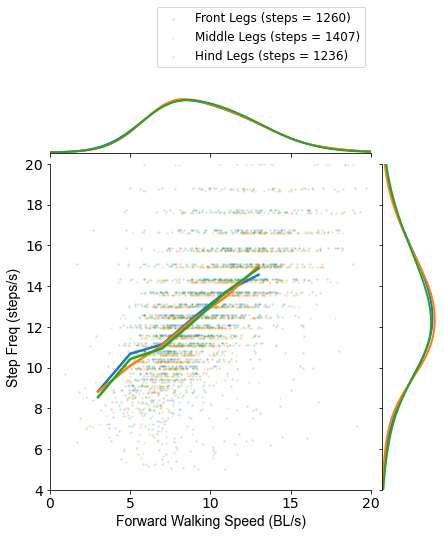

In [127]:
# plot_metric = step_freq 
plot_metric = up_step_freq_distributions
ylabel_name = 'Step Freq (steps/s)'
fig_name = 'step_freq_flybowl'
p_coeff = 1
plot_scatter = True
ylim = [4, 20]
add_offset = True
offset_val = 0.075
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim, add_offset, offset_val, figure_dir)


C:\Users\pratt\AppData\Local\Temp\ipykernel_10404\3852449614.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


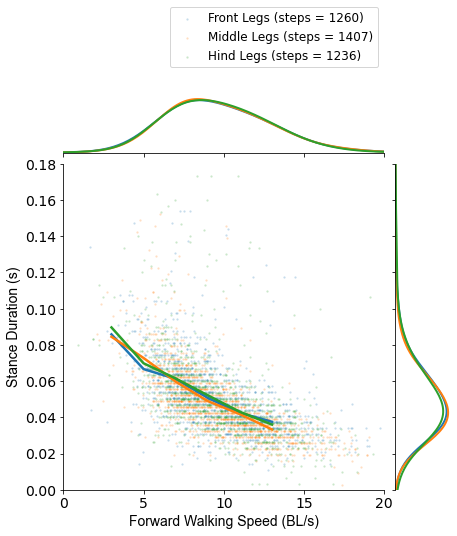

In [107]:
# plot_metric = stance 
plot_metric = up_stance_duration_distributions
ylabel_name = 'Stance Duration (s)'
fig_name = 'stance_duration_flybowl'
p_coeff = 2
plot_scatter = True
ylim = [0, 0.18]
add_offset = True
offset_val = 0.00085
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val, figure_dir)

In [134]:
np.mean(up_swing_duration_distributions[0][1,:])

0.03237566137566138

C:\Users\pratt\AppData\Local\Temp\ipykernel_10404\3852449614.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


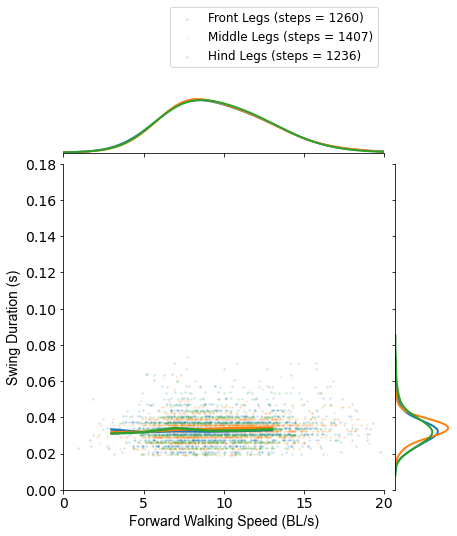

In [108]:
# plot_metric = swing 
plot_metric = up_swing_duration_distributions
ylabel_name = 'Swing Duration (s)'
fig_name = 'swing_duration_flybowl'
p_coeff = 1
plot_scatter = True
ylim = [0, 0.18]
add_offset = True
offset_val = 0.00085
# ylim = [0.015, 0.075]
# add_offset = True
# offset_val = 0.0004
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val, figure_dir)

C:\Users\pratt\AppData\Local\Temp\ipykernel_10404\3852449614.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


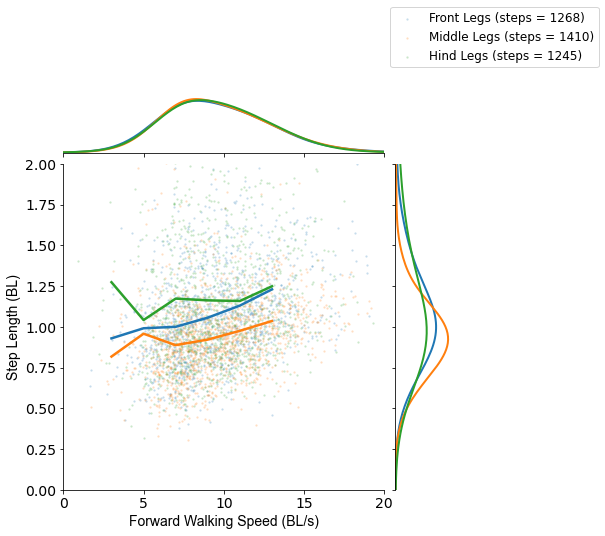

In [109]:
plot_metric = step_length_distributions
ylabel_name = 'Step Length (BL)'
fig_name = 'step_length_flybowl'
p_coeff = 1
plot_scatter = True
ylim = [0, 2]
# xlim = [0, 50]
add_offset = False
offset_val = 0.0078
plot_intralimb_kinematics_marginal_distribution(plot_metric, ylabel_name, fig_name, p_coeff, plot_scatter, ylim,add_offset, offset_val, figure_dir)

### save metrics for statistical comparison

In [130]:
def save_intralimb_kinematic_data(metric, metric_name, figure_dir):
    cnt = -3
    for leg in range(3):
        cnt += 3
        slow_data = metric[leg][1,:][metric[leg][0,:]<6]
        int_data = metric[leg][1,:][np.logical_and(metric[leg][0,:]>=6, metric[leg][0,:]<=10)]
        fast_data = metric[leg][1,:][metric[leg][0,:]>10]

        if leg == 0:
            cat_data = np.concatenate((slow_data, int_data, fast_data))
            cat_id = np.concatenate((cnt*np.ones(len(slow_data)), (cnt+1)*np.ones(len(int_data)), (cnt+2)*np.ones(len(fast_data))))
        else:
            cat_data = np.concatenate((cat_data, slow_data, int_data, fast_data))
            cat_id = np.concatenate((cat_id, cnt*np.ones(len(slow_data)), (cnt+1)*np.ones(len(int_data)), (cnt+2)*np.ones(len(fast_data))))

    # combine data and id arrays
    cat_array = np.vstack((cat_data, cat_id))
    np.save(figure_dir+metric_name+'.npy', cat_array)

In [131]:
save_intralimb_kinematic_data(up_step_freq_distributions, 'upsampled_step_freq', figure_dir)
save_intralimb_kinematic_data(up_stance_duration_distributions, 'upsampled_stance_duration', figure_dir)
save_intralimb_kinematic_data(up_swing_duration_distributions, 'upsampled_swing_duration', figure_dir)
save_intralimb_kinematic_data(step_length_distributions, 'step_length', figure_dir)

### Inter-leg coordination

#### Probability of the number of legs in stance

In [119]:
speed_dist = vel_store.flatten()
nlegs_dist = nlegs_store.flatten()

beh_ids = fw_class_store.flatten()

# isolate forward walking
fw_nlegs = nlegs_dist[beh_ids==1]
fw_vel = speed_dist[beh_ids==1]

# filter nlegs - remove nans
fw_vel = fw_vel[~np.isnan(fw_nlegs)]
fw_nlegs = fw_nlegs[~np.isnan(fw_nlegs)]


# edges of distributions
vel_bins = 6
# vel_grid = np.linspace(np.min(fw_vel), np.max(fw_vel), vel_bins)
vel_grid = np.linspace(2, 18, vel_bins)
vel_center = np.around(vel_grid[1::] - (vel_grid[1]-vel_grid[0]),2)
nleg_cat = np.unique(fw_nlegs)

# compute probability distribution for each of the nleg categories
nleg_prob = np.zeros((len(nleg_cat), len(vel_center)))
for j in range(len(nleg_cat)):
    leg_idxs = np.where(fw_nlegs == nleg_cat[j])[0]
    for i in range(len(vel_center)):
        nleg_vels = fw_vel[leg_idxs]
        nleg_prob[j,i] = len(np.where(np.logical_and(nleg_vels>=vel_grid[i], nleg_vels<=vel_grid[i+1])==True)[0])
        
nleg_prob = nleg_prob/np.sum(nleg_prob, axis = 0)


In [120]:
print('Number of frames = ', len(fw_nlegs))

Number of frames =  11477


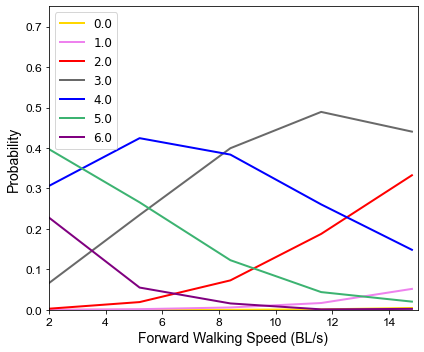

In [121]:
# plot the probability of a certain number of legs in stance
fig = plt.figure(1, figsize = [6,5])
# plt.style.use('ggplot')
plt_colors = ['gold', 'violet', 'red', 'dimgray', 'blue', 'mediumseagreen', 'purple']
for j in range(nleg_prob.shape[0]):
    plt.plot(vel_center, nleg_prob[j,:], linewidth =2, color = plt_colors[j])

# axis properties
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xlabel('Forward Walking Speed (BL/s)', fontsize = 14, fontname = 'Arial')
plt.ylabel('Probability', fontsize = 14, fontname = 'Arial')
plt.xlim([2, 15])
plt.ylim([0, 0.75])

plt.legend(nleg_cat.astype(str), fontsize =12)
plt.grid(False)
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'nleg_stance_prob'+'.png', dpi = 300)
fig.savefig(figure_dir + 'nleg_stance_prob'+'.pdf', dpi = 300)
fig.savefig(figure_dir + 'nleg_stance_prob'+'.svg', dpi = 300)

#### relative phase

In [113]:
# calculate mean of polar distributions by transforming them into cartesian coordinates then back to polar coordinates
def estimate_ang_stats(var):
#     mean_angle = np.arctan2(np.nanmedian(np.sin(var)), np.nanmedian(np.cos(var)))
    mean_angle = np.arctan2(np.nanmean(np.sin(var)), np.nanmean(np.cos(var)))
    angular_dispersion = np.sqrt(np.nanmean(np.sin(var))**2 + np.nanmean(np.cos(var))**2) # 0: uniform, 1: concetrated in one directtion
    return mean_angle, angular_dispersion

def compute_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(0.0,2*np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

# transform phase values to between -np.pi to np.pi
def transform_half_polar(var):
    var[var>np.pi] = var[var>np.pi] - (2*np.pi)
    return var

def full_distribution_transform_polar(var):
    var[var<0] = np.pi + np.abs(-np.pi - var[var<0])
    return var

def compute_inphase_histogram(var, N):
    hist, bin_edges = np.histogram(var, bins=N, range=(-np.pi, np.pi), density=True)
    bin_centers = bin_edges[1::] - ((bin_edges[1]- bin_edges[0])/2)
    return hist, bin_centers 

# function that transforms that space from 0 to pi to 0 to 2pi
def transform_polar(org_val):
    if org_val < 0: # only need to transform negative values to extend the space to 2pi
        transformed_val = np.pi + np.abs(-np.pi - org_val)
    else: 
        transformed_val = org_val
        
    return transformed_val

In [114]:
# relative phase distributions - to L1
relative_leg = [3, 3, 3, 3, 3] # L1-R1, L1-R2, L1-R3, L1-L2, L1-L3
inphase_comparasions = [1,4]
full_phase_dist = []

# iterate through phase comparasions
for p in range(len(relative_leg)):

    vel_data = np.transpose(vel_store).flatten()
    phase_data = step_phase_store[p, :, :].flatten()
    beh_ids = np.transpose(fw_class_store).flatten()

    # forward walking data
    fw_vel_data = vel_data[beh_ids==1]
    fw_phase_data = phase_data[beh_ids==1]

    # filter data - remove negative 1 and nan values
    filt_vel = fw_vel_data[fw_phase_data != -1]
    filt_phase = fw_phase_data[fw_phase_data != -1]

    filt_vel = filt_vel[~np.isnan(filt_phase)]
    filt_phase = filt_phase[~np.isnan(filt_phase)]

    # split phase into the different walking speed categories - rescale from 0-1 to 0-2pi
    slow_phase = filt_phase[filt_vel<6]*(2*np.pi)
    intermediate_phase = filt_phase[np.logical_and(filt_vel>=6, filt_vel<=10)]*(2*np.pi)
    fast_phase = filt_phase[filt_vel>10]*(2*np.pi)
        

    # distributions
    if p in inphase_comparasions:
        cat_slow = transform_half_polar(slow_phase)
        cat_intermediate = transform_half_polar(intermediate_phase)
        cat_fast = transform_half_polar(fast_phase)
    else:
        cat_slow = slow_phase
        cat_intermediate = intermediate_phase
        cat_fast = fast_phase
        
    # store full phase distributions
    full_phase_dist.append([cat_slow, cat_intermediate, cat_fast])
    

#### save full distributions

In [115]:
# relative phase distributions - to L1
metric_name = ['L1_R1', 'L1_R2', 'L1_R3', 'L1_L2', 'L1_L3']
relative_leg = [3, 3, 3, 3, 3] # L1-R1, L1-R2, L1-R3, L1-L2, L1-L3
inphase_comparasions = [1,4]
save_phase_dist = []

# iterate through phase comparasions
for p in range(len(relative_leg)):

    vel_data = np.transpose(vel_store).flatten()
    phase_data = step_phase_store[p, :, :].flatten()
    beh_ids = np.transpose(fw_class_store).flatten()

    # forward walking data
    fw_vel_data = vel_data[beh_ids==1]
    fw_phase_data = phase_data[beh_ids==1]

    # filter data - remove negative 1 and nan values
    filt_vel = fw_vel_data[fw_phase_data != -1]
    filt_phase = fw_phase_data[fw_phase_data != -1]

    filt_vel = filt_vel[~np.isnan(filt_phase)]
    filt_phase = filt_phase[~np.isnan(filt_phase)]
    filt_phase_adj = filt_phase*(2*np.pi)

    # distributions
    if p in inphase_comparasions:
        cat_phase = transform_half_polar(filt_phase_adj)
    else:
        cat_phase = filt_phase_adj
    
    # store full phase distributions
#     save_phase_dist.append(cat_phase)
    np.save(figure_dir + metric_name[p] +'.npy', cat_phase)
    

#### Plot speed-dependent phase distributions

In [39]:
# determine average amount of data associated with each step
slow_steps = 0
intermediate_steps = 0
fast_steps = 0
for j in range(5):
    slow_steps += len(full_phase_dist[j][0])
    intermediate_steps += len(full_phase_dist[j][1])
    fast_steps += len(full_phase_dist[j][2])
    
print('Number of Slow Comparisons = ', int(slow_steps/5))
print('Number of Intermediate Comparisons = ', int(intermediate_steps/5))
print('Number of Fast Comparisons = ', int(fast_steps/5))

Number of Slow Comparisons =  77
Number of Intermediate Comparisons =  314
Number of Fast Comparisons =  235


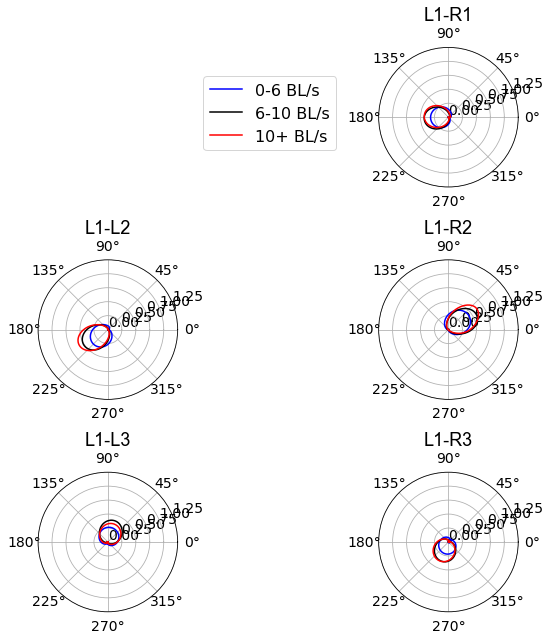

In [116]:
# plot relative phase to L1 - histograms
compare_labels = ['L1-R1', 'L1-R2', 'L1-R3','L1-L2', 'L1-L3']
plt_colors = ['blue', 'black', 'red']
plt_axes = [[0,1],[1,1],[2,1],[1,0],[2,0]]
speed_labels = ['0-6 BL/s', '6-10 BL/s', '10+ BL/s']

fig, axs = plt.subplots(3,2, figsize =[8,9], sharex=True, sharey=True, subplot_kw={'projection': 'polar'})
for p in range(len(relative_leg)):
    for j in range(3): # walking speed bins
                
        # plot distribution
        sea.kdeplot(ax= axs[plt_axes[p][0], plt_axes[p][1]], x=full_phase_dist[p][j], color = plt_colors[j], linewidth = 1.5, zorder=10, label = speed_labels[j], bw_adjust=2) 
        
    # plot parameters
    axs[plt_axes[p][0], plt_axes[p][1]].tick_params(axis='both', labelsize=14)
    axs[plt_axes[p][0], plt_axes[p][1]].set_ylabel(None)
    axs[plt_axes[p][0], plt_axes[p][1]].set_title(compare_labels[p], fontsize=18, fontname="Arial")
#     axs[plt_axes[p][0], plt_axes[p][1]].set_ylim([0,1.2])
    axs[plt_axes[p][0], plt_axes[p][1]].set_rticks(np.arange(0,1.26,0.25))
    
    if p ==0:
        axs[plt_axes[p][0], plt_axes[p][1]].legend(fontsize = 16, bbox_to_anchor=(-0.25, 0.85))
        
axs[0,0].axis('off')
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.png', dpi = 300)
fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.pdf', dpi = 300)
fig.savefig(figure_dir + 'L1_relative_phase_full_distribution.svg', dpi = 300)

#### Step Order

In [128]:
# Determine Step order of the legs within a tripod
leg_order_classification = []
for trial in range(step_phase_store[0].shape[1]):
    # Right Tripod Legs
    l1_r1_idxs = np.where(np.logical_and.reduce((step_phase_store[0][:,trial] != -1, ~np.isnan(step_phase_store[0][:,trial]), fw_class_store[trial, :] == 1)) == True)[0]
    l1_l2_idxs = np.where(np.logical_and.reduce((step_phase_store[3][:,trial] != -1, ~np.isnan(step_phase_store[3][:,trial]), fw_class_store[trial, :] == 1)) == True)[0]
    l1_r3_idxs = np.where(np.logical_and.reduce((step_phase_store[2][:,trial] != -1, ~np.isnan(step_phase_store[2][:,trial]), fw_class_store[trial, :] == 1)) == True)[0]
    r_same_idxs = np.intersect1d(l1_r3_idxs, np.intersect1d(l1_r1_idxs, l1_l2_idxs))

    if len(r_same_idxs) > 0: # common frames were detected
        # phase values for right tripod legs
        l1_r1_trial_vals = step_phase_store[0][r_same_idxs,trial]
        l1_l2_trial_vals = step_phase_store[3][r_same_idxs,trial]
        l1_r3_trial_vals = step_phase_store[2][r_same_idxs,trial]

        # Classify step order into categories
        for j in range(len(l1_r1_trial_vals)):
            if (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(7)
            elif (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(4)
            elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(8)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] < l1_r1_trial_vals[j]):
                leg_order_classification.append(9)
            elif (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_r3_trial_vals[j]):
                leg_order_classification.append(10)
            elif (l1_l2_trial_vals[j] > l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(1)
            elif (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]) and (l1_r1_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(5)
            elif (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(0)
            elif (l1_r1_trial_vals[j] == l1_r3_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(6)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_r1_trial_vals[j]):
                leg_order_classification.append(2)
            elif (l1_r1_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_r3_trial_vals[j] > l1_l2_trial_vals[j]):
                leg_order_classification.append(3)
            elif (l1_r3_trial_vals[j] == l1_l2_trial_vals[j]) and (l1_l2_trial_vals[j] == l1_r1_trial_vals[j]):
                leg_order_classification.append(11)

    # Left Tripod Legs
    l1_r2_idxs = np.where(np.logical_and.reduce((step_phase_store[1][:,trial] != -1, ~np.isnan(step_phase_store[1][:,trial]), fw_class_store[trial, :] == 1)) == True)[0]
    l1_l3_idxs = np.where(np.logical_and.reduce((step_phase_store[4][:,trial] != -1, ~np.isnan(step_phase_store[4][:,trial]), fw_class_store[trial, :] == 1)) == True)[0]
    l_same_idxs = np.intersect1d(l1_r2_idxs, l1_l3_idxs)

    if len(l_same_idxs) > 0:
        # phase values for left tripod legs
        l1_r2_trial_vals = step_phase_store[1][l_same_idxs,trial]
        l1_l3_trial_vals = step_phase_store[4][l_same_idxs,trial]

        # correct for the wrap around
        l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] = l1_r2_trial_vals[l1_r2_trial_vals >= 0.5] -1
        l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] = l1_l3_trial_vals[l1_l3_trial_vals >= 0.5] -1

        # Classify step order into categories
        for j in range(len(l1_r2_trial_vals)):
            if (0 > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
                leg_order_classification.append(7)
            elif (0 > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
                leg_order_classification.append(4)
            elif (0 == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]):
                leg_order_classification.append(8)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] < 0): # front leg occurs last
                leg_order_classification.append(9)
            elif (l1_r2_trial_vals[j] > 0) and (0 > l1_l3_trial_vals[j]):
                leg_order_classification.append(10)
            elif (l1_r2_trial_vals[j] > l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(1)
            elif (l1_l3_trial_vals[j] > 0) and (0 > l1_r2_trial_vals[j]):
                leg_order_classification.append(5)
            elif (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] > 0):
                leg_order_classification.append(0)
            elif (0 == l1_l3_trial_vals[j]) and (l1_l3_trial_vals[j] > l1_r2_trial_vals[j]):
                leg_order_classification.append(6)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(2)
            elif (0 == l1_r2_trial_vals[j]) and (l1_l3_trial_vals[j] > 0):
                leg_order_classification.append(3)
            elif (l1_l3_trial_vals[j] == l1_r2_trial_vals[j]) and (l1_r2_trial_vals[j] == 0):
                leg_order_classification.append(11)

# convery into an array
leg_order_classification = np.array(leg_order_classification)
print('Number of Steps = ', len(leg_order_classification))

# determine the proportion of each category represented
category_proportion = np.zeros(12)

for j in range(len(category_proportion)):
    category_proportion[j] = len(np.where(leg_order_classification == j)[0])/len(leg_order_classification)
    

Number of Steps =  1068


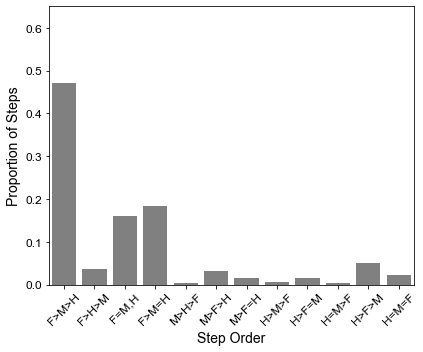

In [133]:
# Plot the proportion of each step type
cat_names = ['F>M>H', 'F>H>M', 'F=M,H','F>M=H', 'M>H>F', 'M>F>H', 'M>F=H', 'H>M>F', 'H>F=M', 'H=M>F', 'H>F>M', 'H=M=F']

fig = plt.figure(1, figsize =  [6,5])
sea.barplot(x= np.arange(0,12), y = category_proportion, color = 'gray')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(np.arange(0,12), cat_names, fontsize = 12, fontname = 'Arial', rotation = 45)
plt.ylabel('Proportion of Steps', fontsize = 14, fontname = 'Arial')
plt.xlabel('Step Order', fontsize = 14, fontname = 'Arial')
plt.ylim([0,0.65])
plt.tight_layout()
plt.show()

fig.savefig(figure_dir + 'step_order.png', dpi = 300)
fig.savefig(figure_dir + 'step_order.pdf', dpi = 300)
fig.savefig(figure_dir + 'step_order.svg', dpi = 300)